In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import urllib.request
import seaborn as sns
import tensorflow as tf
import numpy as np

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, \
  GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3, \
  preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, \
  ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

from itertools import product
from functools import partial

In [15]:
train_dir = 'C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\chest_xray\\chest_xray\\train\\'
validation_dir = 'C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\chest_xray\\chest_xray\\val\\'
test_dir = 'C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\'

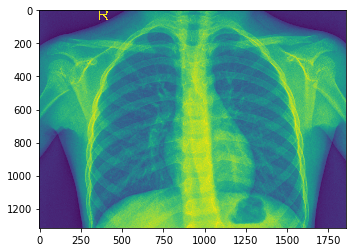

In [4]:
img = mpimg.imread('C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\NORMAL\\IM-0001-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [2]:
pwd

'C:\\Users\\sande\\Downloads'

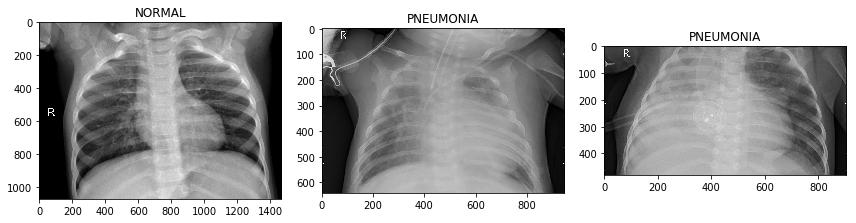

In [5]:
img_normal = plt.imread('C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\NORMAL\\NORMAL2-IM-0354-0001.jpeg')
img_penumonia_bacteria = plt.imread('C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\PNEUMONIA\\person1_virus_6.jpeg')
img_penumonia_virus = plt.imread('C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\chest_xray\\chest_xray\\test\\PNEUMONIA\\person85_bacteria_422.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

In [6]:
K.clear_session()

NUM_CLASSES = 2


def create_model(input_shape):
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  
  x = base_model.output
  x = GlobalAveragePooling2D(name='avg_pool')(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  
  for layer in base_model.layers:
    layer.trainable = False
    
  predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = Model(inputs=base_model.inputs, outputs=predictions)
  return model

model = create_model((150, 150, 3))

training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'training_accuracy', dtype=tf.float32)
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    'test_accuracy', dtype=tf.float32)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 17s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
______________________________________________________

In [7]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(2048, 512) dtype=float32>,
 <tf.Variable 'dense/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(512, 256) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 128) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32>,
 <tf.Variable 'dense_3/kernel:0' shape=(128, 2) dtype=float32>,
 <tf.Variable 'dense_3/bias:0' shape=(2,) dtype=float32>]

In [8]:
# with strategy.scope():
optimizer = Adam(lr=0.0001)
# optimizer = RMSprop()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [16]:
rescale = 1./255
target_size = (150, 150)
batch_size = 163
class_mode = 'categorical'


def dir_file_count(directory):
    return sum([len(files) for r, d, files in os.walk(directory)])


train_datagen = ImageDataGenerator(rescale=rescale,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=target_size,
                                                    class_mode=class_mode,
                                                    batch_size=batch_size,
                                                    shuffle=True)

val_datagen = ImageDataGenerator(rescale=rescale)
val_generator = val_datagen.flow_from_directory(validation_dir, 
                                                target_size=target_size,
                                                class_mode=class_mode,
                                                batch_size=dir_file_count(validation_dir),
                                                shuffle=False)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=target_size,
                                                  class_mode=class_mode,
                                                  batch_size=dir_file_count(test_dir),
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
y = train_generator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight('balanced', labels, y)
print(train_class_weights)

[1.9448173  0.67303226]


In [18]:
# with strategy.scope():
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator),
                              epochs=10,
                              verbose=1,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              class_weight=train_class_weights,
                              workers=20)

MODEL_FILE = 'pneumonia_v0.0.1.hd5'
model.save(MODEL_FILE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
32/32 [==============================] - 498s 16s/step - loss: 0.5987 - acc: 0.7134 - val_loss: 1.0200 - val_acc: 0.5000
Epoch 2/10
32/32 [==============================] - 451s 14s/step - loss: 0.4629 - acc: 0.7841 - val_loss: 0.7411 - val_acc: 0.6250
Epoch 3/10
32/32 [==============================] - 463s 14s/step - loss: 0.3367 - acc: 0.8608 - val_loss: 0.8443 - val_acc: 0.8125
Epoch 4/10
32/32 [==============================] - 482s 15s/step - loss: 0.3055 - acc: 0.8752 - val_loss: 2.2200 - val_acc: 0.5000
Epoch 5/10
32/32 [==============================] - 488s 15s/step - loss: 0.2584 - acc: 0.9009 - val_loss: 1.3221 - val_acc: 0.6875
Epoch 6/10
32/32 [==============================] - 492s 15s/step - loss: 0.2499 - acc: 0.8986 - val_loss: 1.3018 - val_acc: 0.7500
Epoch 7/10
32/32 [==============================] - 477s 15s/step - loss: 0.2534 - acc: 0.8970 - val_loss: 1.3955 - val_acc: 0.6875
Epoch 8/10
32/32 [==========

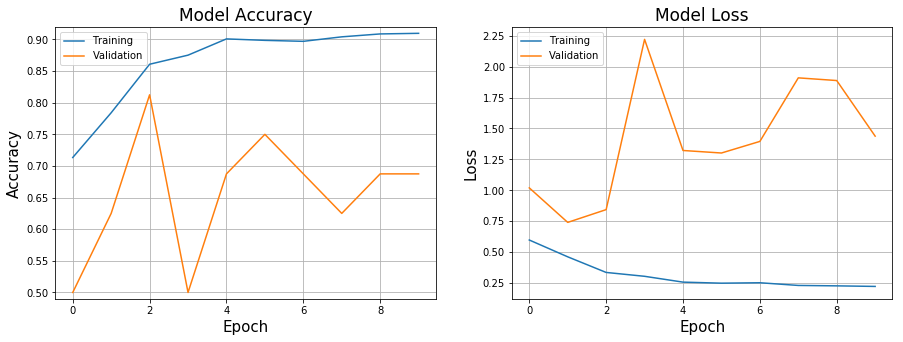

In [20]:

xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

In [24]:
MODEL_FILE = 'C:\\Users\\sande\\Downloads\\chest-xray-pneumonia\\pneumonia_v0.0.1.hd5'
model = tf.keras.models.load_model(MODEL_FILE)

In [26]:
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

1/1 [==============================] - 56s 56s/step - loss: 1.2195 - acc: 0.7196
Loss     : 1.22  
Accuracy : 71.96%


In [27]:

y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)  
y_pred = y_pred.argmax(axis=-1)
y_true = test_generator.classes

1/1 [==============================] - 62s 62s/step


In [29]:
import random

num_of_batch = len(test_generator)
batch_no = random.randint(0, num_of_batch - 1)

y_img_batch, y_true_batch = test_generator.__getitem__(batch_no)
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)

print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 0
-----------------------------------
Batch Size              : 624
-----------------------------------
Accuracy                : 71.96%
-----------------------------------
